# Recurrent Neural Network for Disaster Tweets 

## Introduction

This project consists of a Recurrent Neural Network which determines whether or not a given tweet describes a real disaster. The data set from this project comes from the Kaggle competition here:

https://www.kaggle.com/competitions/nlp-getting-started/

The github repo for my project can be found here:



## Exploratory Data Analysis

The training data for this project consists of a csv containing the columns id (an id number for the tweet), keyword (an important keyword from the tweet), location (where the tweet came from), text (the content of the tweet itself), and target (whether or not the tweet describes an actual disaster; encoded as 1 for yes and 0 for no). 

### Visualization

You can see below that the target variable is skewed slightly toward 0 but this isn't necessarily an issue.

In [2]:
import pandas as pd

df = pd.read_csv('train.csv')

array([[<Axes: title={'center': 'target'}>]], dtype=object)

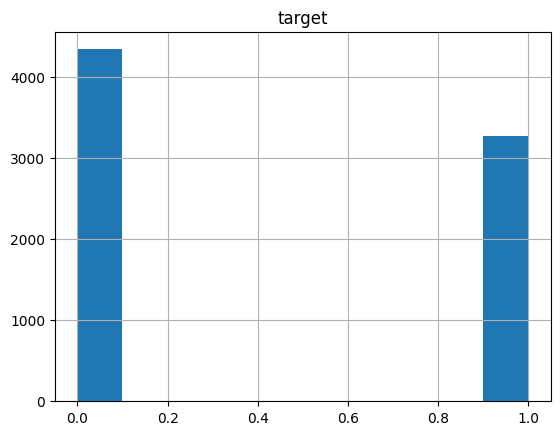

In [3]:
df.hist('target')

### Text Examples

Tweets with a 0 target, which do not describe a disaster, look like this:

In [4]:
list(df[df['target']==0]['text'].values[0:5])

["What's up man?",
 'I love fruits',
 'Summer is lovely',
 'My car is so fast',
 'What a goooooooaaaaaal!!!!!!']

We can see that they do not necessarily mention anything about a disaster, real or fictional, but may be about pretty much anything.

In contrast, tweets whose target is 1, which do describe a disaster, look like this:

In [5]:
list(df[df['target']==1]['text'].values[0:5])

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']

They, conveniently, clearly describe something terrible or unfortunate. In fact, even a pretty simple model performs reasonably well, as we'll see below.

## Model Architecture

### Simple Supervised Model for Comparison

#### Data Pre-Processing

Before we get into modeling, I'll convert the texts into vectors. First, I'll create word frequencies using CountVectorizer.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectors = CountVectorizer().fit_transform(df['text']).toarray()

Now, I'll split all of these into training and test sets, since we can't test on the actual test data.

In [7]:
train_counts = count_vectors[:int(len(df)*.8)]
train_targets = df['target'][:int(len(df)*.8)]
test_counts = count_vectors[int(len(df)*.8):]

test_targets = df['target'][int(len(df)*.8):]

#### Supervised Model Training
Below, I've trained a Supervised Classifer on the counts just to get a baseline for model performance. The kaggle competition recommends the RidgeClassifier for a supervised model so let's see what we get from that.

In [8]:
from sklearn.linear_model import RidgeClassifier

sup_mod = RidgeClassifier().fit(train_counts, train_targets)


Because the metric for this competition is the F1 score, let's see how this model performs. 

In [9]:
from sklearn.metrics import f1_score

sup_mod_preds = sup_mod.predict(test_counts)


sup_mod_f1 = f1_score(sup_mod_preds, test_targets)

print("Supervised Model F1 Score: " + str(round(sup_mod_f1,4)))

Supervised Model F1 Score: 0.7193


We can see that the performance is not abysmal. But certainly with Deep Learning with can do better.

### RNN Model

#### Data Preprocessing

First, I'll take the dataframe from above and extract just the text and target columns. Then, I'll split that new frame into train and test sets. I've displayed the head of the training dataframe for reference.

In [10]:
from sklearn.model_selection import train_test_split

model_df = df[['text', 'target']]

train, test = train_test_split(model_df, test_size=.2, random_state=0)

train.head()

,text,target
1386,Ted Cruz fires back at Jeb &amp; Bush: ÛÏWe l...,0
4048,This is the first year the Forest Service spen...,1
3086,@lightseraphs pissed at you and could have the...,0
272,I'm gonna fight Taylor as soon as I get there.,0
7462,@NicolaClements4 IÛªm not sure that covering ...,0


#### Creating the Model

Rather than using word counts as above, Keras provides a great text encoder that will be the first layer of the model. This layer normalizes the text by setting all letters to a lowercase value and stripping all punctuation. Then it assigns every unique "token", a word or phrase, a unique integer. This converts our texts into vectors of numbers without losing any of the sequence data that is crucial to RNN modeling.

In [11]:
import numpy as np
from tensorflow import keras
import tensorrt 

2023-08-01 15:29:12.892737: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 15:29:17.112738: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
encoder = keras.layers.TextVectorization()
encoder.adapt(np.array(train['text']))

We can see below that the resulting vectors will be quite large. In fact, every vector will have the length of the full vocabulary. I've displayed this value below.

In [15]:
vocabulary = np.array(encoder.get_vocabulary())

vocab_length = len(vocabulary)

print(vocab_length)

19484


Because this is an extremely large length for vectors we need to perform dimensionality reduction on these vectors. To do this, I'll use an Embedding layer to reduce these down to a length of 64. This number is arbitrary but is small enough to be manageable.

Next, this embedding will be passed to an RNN layer. I've chosed GRU for this to avoid the problems of traditional RNN and for it's simplicity compared to LSTM. I also found in testing that GRU performs slightly better than LSTM on this data set. I've made this layer bidirectional. According to the Keras documentation, non-temporal sequences, sequences that are not necessarily time-based, can benefit from being trained both forwards and backwards. That is, each text is used both in it's original form and reversed.

In testing I found that adding a Dense layer after the GRU layer improves accuracy, much like the CNN architectures we worked with previously. Additional layers did not improve performance, however. 64 units appeared to be optimal as well. Increasing made the model perform significantly worse.

Finally, this is sent to a dense layer of size 1 since this is just a binary classification problem.

In [16]:
model = keras.Sequential([
    encoder,
    keras.layers.Embedding(vocab_length, 64),
    keras.layers.Bidirectional(keras.layers.GRU(64)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, None, 64)          1246976   
                                                                 
 bidirectional (Bidirection  (None, 128)               49920     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1305217 (4.98 MB)
Trainable params: 130521

Below, I've compiled the model. The loss function is Binary Crossentropy since this is a binary classification problem.

For the optimizer, in testing Adam performed substantially better than SGD though it is also more computationally more expensive.

Experimenting with learning rate decay, I found that introducing a learning rate scheduler tended to lead to the model falling into a local extrema with relatively poor accuracy.

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### Training the Model

Here, I've trained the model. I've set the number of epochs to 10. I found that performance tends to stagnate there.

In [19]:
history = model.fit(
    x=train['text'],
    y=train['target'],
    epochs = 15
)

Epoch 1/15


2023-08-01 15:30:37.932762: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-08-01 15:30:38.796482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-01 15:30:40.259710: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f89d0e4c000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-01 15:30:40.259958: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2023-08-01 15:30:40.711249: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-01 15:30:42.219697: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not sup

191/191 [==============================] - 30s 104ms/step - loss: 0.5410 - accuracy: 0.7176
Epoch 2/15
191/191 [==============================] - 7s 34ms/step - loss: 0.2738 - accuracy: 0.8906
Epoch 3/15
191/191 [==============================] - 3s 17ms/step - loss: 0.1231 - accuracy: 0.9545
Epoch 4/15
191/191 [==============================] - 4s 20ms/step - loss: 0.0656 - accuracy: 0.9787
Epoch 5/15
191/191 [==============================] - 3s 16ms/step - loss: 0.0495 - accuracy: 0.9847
Epoch 6/15
191/191 [==============================] - 3s 14ms/step - loss: 0.0321 - accuracy: 0.9910
Epoch 7/15
191/191 [==============================] - 2s 13ms/step - loss: 0.0223 - accuracy: 0.9939
Epoch 8/15
191/191 [==============================] - 2s 13ms/step - loss: 0.0165 - accuracy: 0.9954
Epoch 9/15
191/191 [==============================] - 2s 11ms/step - loss: 0.0119 - accuracy: 0.9956
Epoch 10/15
191/191 [==============================] - 2s 13ms/step - loss: 0.0124 - accuracy: 0.995

### Results/Conclusion

#### Visualizing Training Results

I've visualized the training results. We can see that performance improves steadily until around 10 or 11 epochs.

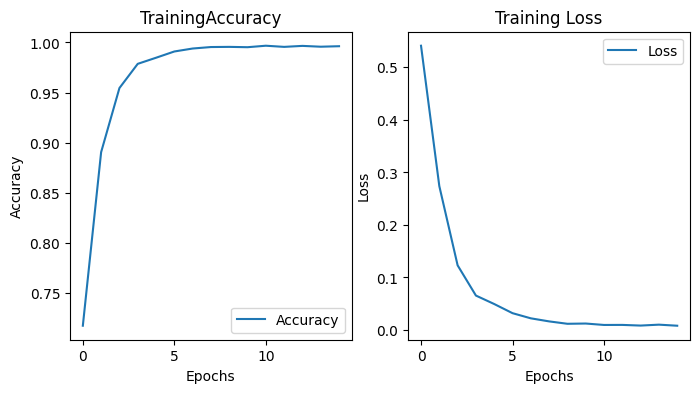

In [20]:
import matplotlib.pyplot as plt

# Training history
history_dict = history.history
  
acc = history_dict['accuracy']
  
loss = history_dict['loss']
  
# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.title('TrainingAccuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy'])
  
plt.subplot(1, 2, 2)
plt.plot(loss)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss'])
  
plt.show()

### F1 Test Results

Now, let's see how this model performs with respect to the F1 metric, the metric this competition is interested in.

First, I'll predict on the test data set and then calculate the F1 using those predictions.

In [21]:
predictions = (model.predict(test['text']) > 0.5).astype("int32")

48/48 [==============================] - 1s 4ms/step


In [22]:
from sklearn.metrics import accuracy_score

mod_f1 = f1_score(predictions.astype(int), test['target'])

mod_acc = accuracy_score(predictions.astype(int), test['target'])

print(mod_f1)

0.7272727272727273


We can see that the RNN model substantially improves on the standard supervised model!

## Predictions for Kaggle

Below I've made predictions for my Kaggle entry. First I've retrained the model using the complete training data.

In [23]:
model.fit(
    x=model_df['text'],
    y=model_df['target'],
    epochs = 10
)

Epoch 1/10
238/238 [==============================] - 3s 13ms/step - loss: 0.1575 - accuracy: 0.9503
Epoch 2/10
238/238 [==============================] - 4s 15ms/step - loss: 0.0626 - accuracy: 0.9781
Epoch 3/10
238/238 [==============================] - 3s 11ms/step - loss: 0.0355 - accuracy: 0.9869
Epoch 4/10
238/238 [==============================] - 3s 11ms/step - loss: 0.0215 - accuracy: 0.9909
Epoch 5/10
238/238 [==============================] - 3s 11ms/step - loss: 0.0217 - accuracy: 0.9904
Epoch 6/10
238/238 [==============================] - 3s 11ms/step - loss: 0.0176 - accuracy: 0.9921
Epoch 7/10
238/238 [==============================] - 3s 12ms/step - loss: 0.0127 - accuracy: 0.9932
Epoch 8/10
238/238 [==============================] - 3s 11ms/step - loss: 0.0110 - accuracy: 0.9941
Epoch 9/10
238/238 [==============================] - 2s 9ms/step - loss: 0.0099 - accuracy: 0.9941
Epoch 10/10
238/238 [==============================] - 3s 15ms/step - loss: 0.0098 - accurac

In [24]:
kaggle_test = pd.read_csv('test.csv')
kaggle_test_data = kaggle_test[['text']]

In [25]:
kaggle_predictions = (model.predict(kaggle_test_data) > 0.5).astype("int32")

102/102 [==============================] - 1s 6ms/step


In [36]:
print(len(list(kaggle_test['id'])))
print(len(list(kaggle_predictions)))

submission = pd.DataFrame({'id':list(kaggle_test['id']), 'target':(x[0] for x in list(kaggle_predictions))})

submission.head()

3263
3263


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [38]:
submission.to_csv('submission.csv', index=False)